In [1]:
# This file will aggregate bridge and tunnel data by week

from __future__ import print_function
import sys
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import weekofyear
from pyspark.sql import functions as f
from pyspark.sql.functions import concat_ws

spark = SparkSession.builder.appName("Agg_Bridges-Max").getOrCreate()

In [35]:
bridges = spark.read.format('csv').options(header='true', inferschema='true').load("New_Bridges_Tunnels.csv")
bridges = bridges.withColumn("month", f.substring("Date", 0, 2)).withColumn("day", f.substring("Date", 4, 2)).withColumn("Year", f.substring("Date", 7, 4))

In [36]:
bridges = bridges.select(concat_ws('-', bridges.Year, bridges.month, bridges.day).alias("NewDate"), "# Vehicles - E-ZPass", "# Vehicles - VToll", "Direction", "Year")
bridges = bridges.withColumn('Week_of_year_temp', weekofyear(f.to_date(bridges["NewDate"])))
bridges = bridges.withColumn('Week_of_year',f.when(bridges.Week_of_year_temp != 53, bridges.Week_of_year_temp).otherwise(0)).drop(bridges.Week_of_year_temp)

In [37]:
bridges.select(bridges["Week_of_year"],bridges["NewDate"]).where(bridges["Week_of_year"] == 0).distinct().orderBy('Week_of_year','NewDate').show(200,False)

+------------+----------+
|Week_of_year|NewDate   |
+------------+----------+
|0           |2010-01-01|
|0           |2010-01-02|
|0           |2010-01-03|
|0           |2015-12-28|
|0           |2015-12-29|
|0           |2015-12-30|
|0           |2015-12-31|
|0           |2016-01-01|
|0           |2016-01-02|
|0           |2016-01-03|
|0           |2020-12-28|
|0           |2020-12-29|
|0           |2020-12-30|
|0           |2020-12-31|
|0           |2021-01-01|
|0           |2021-01-02|
|0           |2021-01-03|
+------------+----------+



In [38]:
bridges = bridges.select((bridges["# Vehicles - E-ZPass"] + bridges["# Vehicles - VToll"]).alias('Total_Vehicles'), "Direction", "Year", "Week_of_year")
bridges = bridges.groupBy('Week_of_year', 'Year', 'Direction').agg(f.sum('Total_Vehicles').alias('Sum_Total_Vehicles')).orderBy('Year', 'Week_of_year')

In [39]:
bridges.show()

+------------+----+---------+------------------+
|Week_of_year|Year|Direction|Sum_Total_Vehicles|
+------------+----+---------+------------------+
|           0|2010|        I|            670560|
|           0|2010|        O|            640472|
|           1|2010|        I|           2006667|
|           1|2010|        O|           1873267|
|           2|2010|        I|           2078746|
|           2|2010|        O|           1946709|
|           3|2010|        O|           1931317|
|           3|2010|        I|           2051476|
|           4|2010|        I|           2034087|
|           4|2010|        O|           1904952|
|           5|2010|        O|           1867840|
|           5|2010|        I|           1975115|
|           6|2010|        I|           1826020|
|           6|2010|        O|           1699639|
|           7|2010|        I|           2049705|
|           7|2010|        O|           1948413|
|           8|2010|        I|           1770938|
|           8|2010| 

In [40]:
ingoing = bridges.where(bridges["Direction"] == "I").select('Sum_Total_Vehicles','Year','Week_of_year').toPandas()
outgoing = bridges.where(bridges["Direction"] == "O").select('Sum_Total_Vehicles','Year','Week_of_year').toPandas()

In [42]:
import altair as alt
import pandas as pd

In [45]:
ingoing_chart = alt.Chart(ingoing).mark_line().encode(
    x='Week_of_year',
    y='Sum_Total_Vehicles',
    color='Year',
    strokeDash='Year',
).properties(title='Inbound: Total Vehicles').interactive()

outgoing_chart = alt.Chart(outgoing).mark_line().encode(
    x='Week_of_year',
    y='Sum_Total_Vehicles',
    color='Year',
    strokeDash='Year',
).properties(title='Outbound: Total Vehicles').interactive()

alt.hconcat(
   ingoing_chart,
   outgoing_chart,
)

alt.HConcatChart(...)

In [46]:
ingoing_20 = bridges.where(bridges["Direction"] == "I").where(bridges["year"] =='2020').select('Sum_Total_Vehicles').toPandas()
outgoing_20 = bridges.where(bridges["Direction"] == "O").where(bridges["year"] =='2020').select('Sum_Total_Vehicles').toPandas()
ingoing_19 = bridges.where(bridges["Direction"] == "I").where(bridges["year"] =='2019').select('Sum_Total_Vehicles').toPandas()
outgoing_19 = bridges.where(bridges["Direction"] == "O").where(bridges["year"] =='2019').select('Sum_Total_Vehicles').toPandas()

<AxesSubplot:>

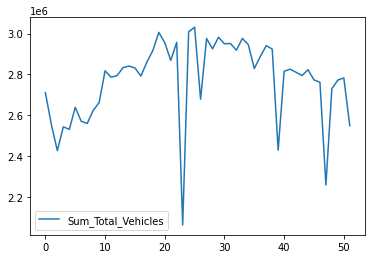

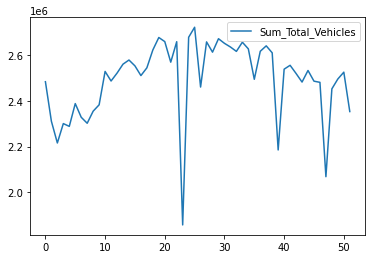

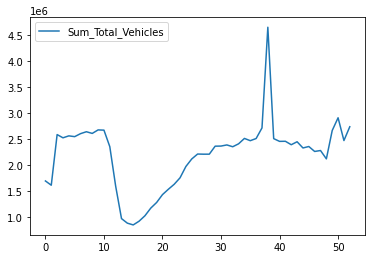

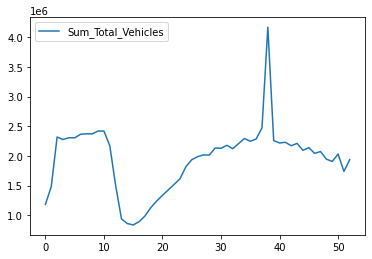

In [47]:
ingoing_19.plot.line()
outgoing_19.plot.line()
ingoing_20.plot.line()
outgoing_20.plot.line()

In [7]:
bridges.coalesce(1).write.option("header", True).csv("Weekly_Volume_Bridges_Tunnels.csv")


AnalysisException: path file:/Users/maximilianchrist/GitHub/Big-Data-Project-X/data/cleaned/Weekly_Volume_Bridges_Tunnels.csv already exists.

In [ ]:
spark.stop()